<a href="https://colab.research.google.com/github/shahdmohamed123/DEPI-Land-type-classification/blob/main/Eurosat_DEPI_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ahmedeleawa_eurosat_rgb_path = kagglehub.dataset_download('ahmedeleawa/eurosat-rgb')

print('Data source import complete.')


100%|██████████| 89.6M/89.6M [00:01<00:00, 55.1MB/s]

Extracting files...


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import kagglehub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import itertools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import tifffile as tiff

In [ ]:
ahmedeleawa_eurosat_path = kagglehub.dataset_download('ahmedeleawa/eurosat-rgb')

dataset_path = ahmedeleawa_eurosat_path

print("Dataset downloaded to:", dataset_path)

if os.path.exists(dataset_path):
    print("Files in dataset:", os.listdir(dataset_path))
else:
    print(f"Error: Directory not found: {dataset_path}")
    print("Please ensure the dataset was downloaded successfully and the path is correct.")

Dataset downloaded to: /root/.cache/kagglehub/datasets/ahmedeleawa/eurosat-rgb/versions/1
Files in dataset: ['2750']


# **Paths**

In [ ]:
tif_dir = "/root/.cache/kagglehub/datasets/ahmedeleawa/eurosat-rgb/versions/1/2750"

dirs = os.listdir(tif_dir)

images = [item for item in dirs if os.path.isdir(os.path.join(tif_dir, item))]

for image in images:
    print(image)

HerbaceousVegetation
Forest
SeaLake
AnnualCrop
Pasture
Highway
River
Residential
PermanentCrop
Industrial


**Data Representation**

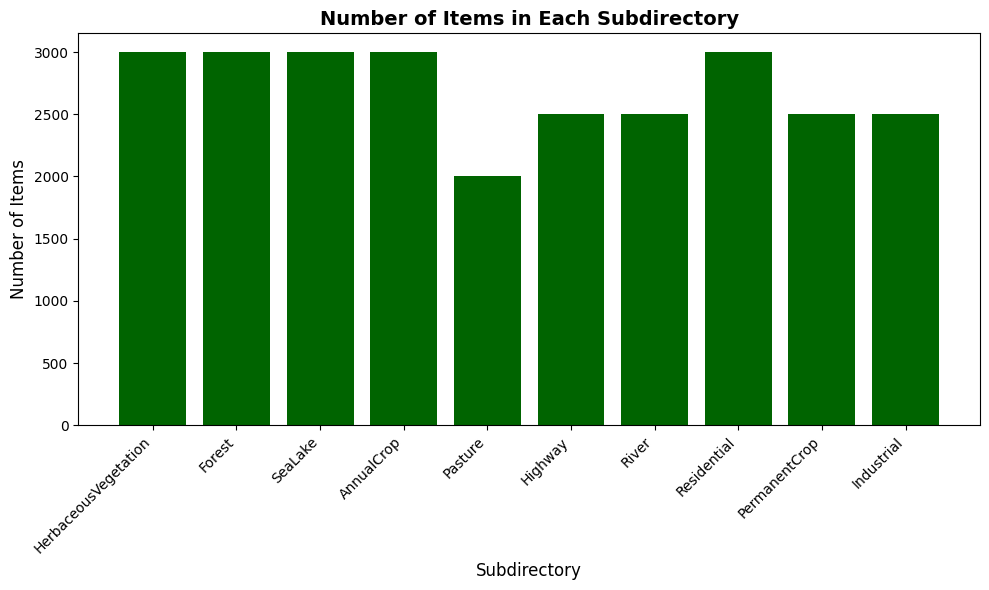

In [ ]:
import matplotlib.pyplot as plt

counts = {}
for image in images:
    counts[image] = len(os.listdir(os.path.join(tif_dir, image)))

item_counts = [counts[image] for image in images]

plt.figure(figsize=(10, 6))
plt.bar(images, item_counts, color='darkgreen')
plt.xlabel("Subdirectory", fontsize=12)
plt.ylabel("Number of Items", fontsize=12)
plt.title("Number of Items in Each Subdirectory", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()

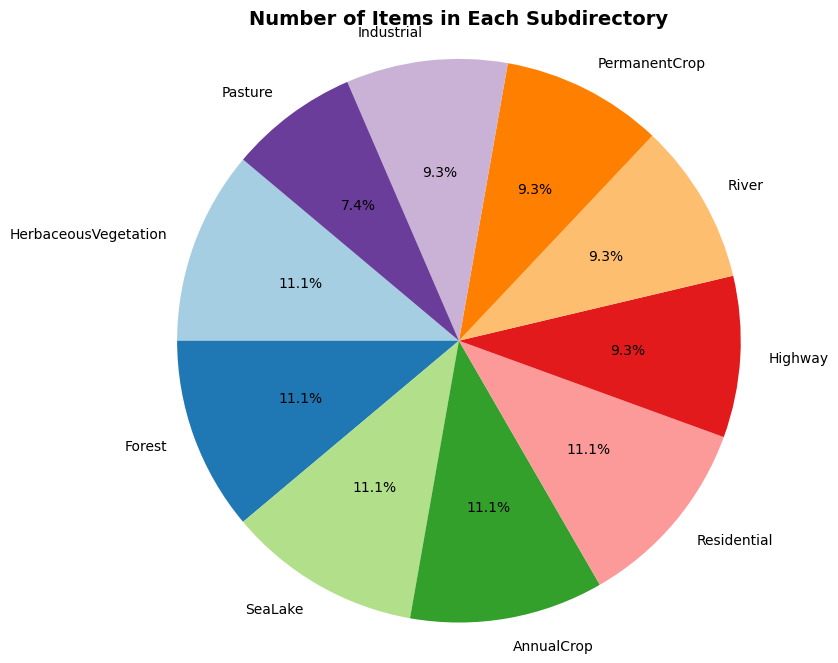

In [ ]:
counts = {}
for image in images:
    counts[image] = len(os.listdir(os.path.join(tif_dir, image)))

sorted_images = sorted(counts.items(), key=lambda x: x[1], reverse=True)

sorted_images, sorted_counts = zip(*sorted_images)

plt.figure(figsize=(8, 8))
plt.pie(sorted_counts, labels=sorted_images, autopct='%1.1f%%', colors=plt.cm.Paired.colors, startangle=140)
plt.title("Number of Items in Each Subdirectory", fontsize=14, fontweight='bold')
plt.axis('equal')
plt.show()


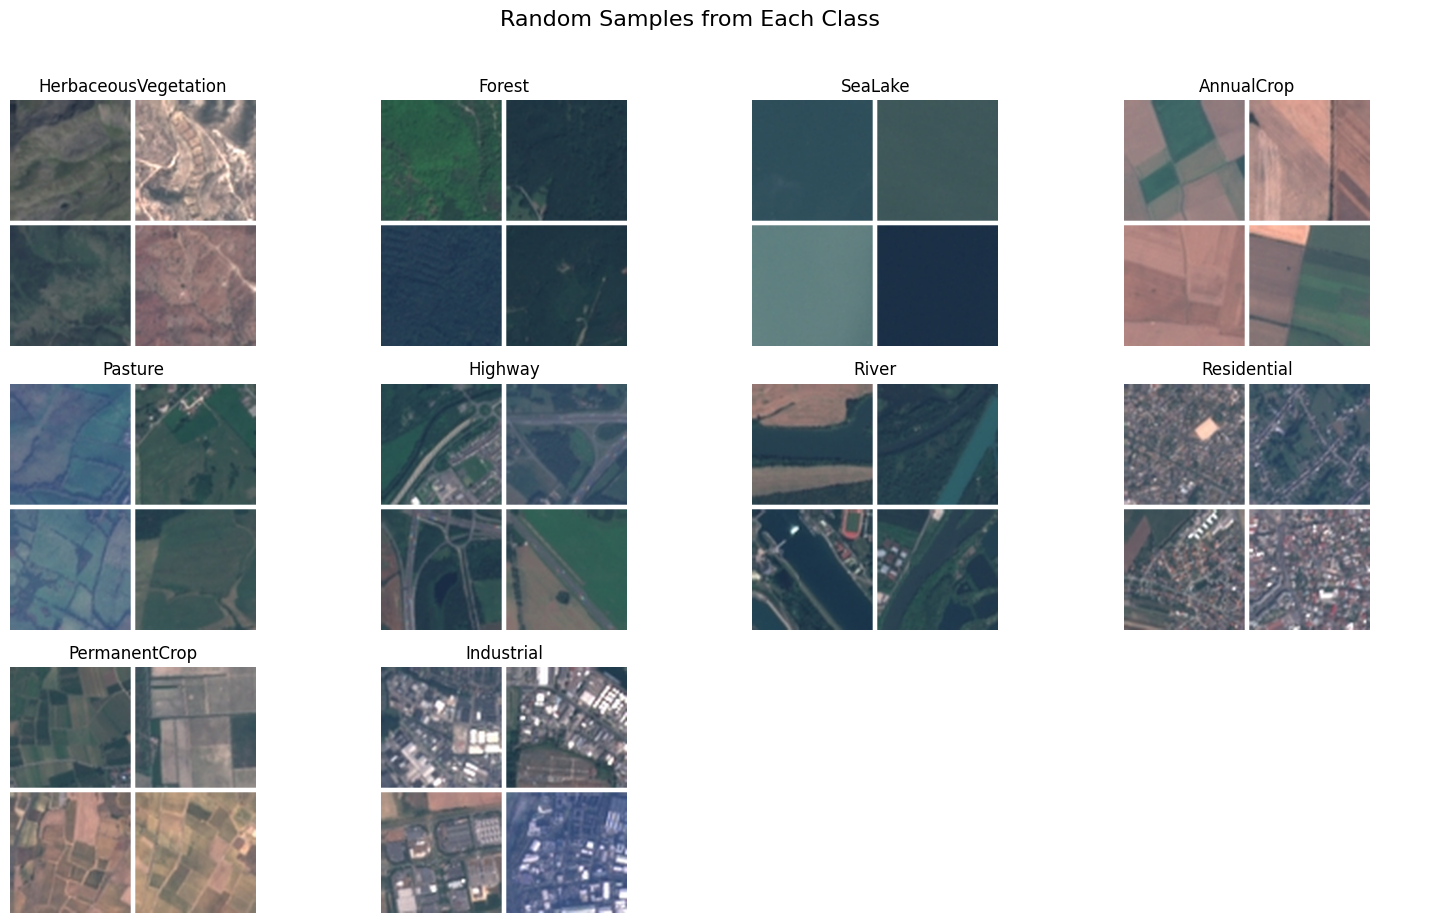

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

# Define the base directory and subdirectories
base_dir = "/root/.cache/kagglehub/datasets/ahmedeleawa/eurosat-rgb/versions/1/2750"
sub_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Function to load random images from a subdirectory
def load_random_images(sub_dir, num_images=4):
    dir_path = os.path.join(base_dir, sub_dir)
    images = [f for f in os.listdir(dir_path) if f.endswith(('.jpg', '.png'))]
    selected_images = random.sample(images, min(num_images, len(images)))  # Handle cases with <4 images
    return [Image.open(os.path.join(dir_path, img_name)) for img_name in selected_images]

# Function to create a 2x2 grid image from 4 images with borders
def create_image_grid(images, border_size=5):
    w, h = 128, 128  # Set fixed size for consistency
    images = [ImageOps.fit(img, (w, h), Image.LANCZOS) for img in images]  # Resize without distortion

    grid_image = Image.new("RGB", (2 * w + border_size, 2 * h + border_size), (255, 255, 255))  # White background
    positions = [(0, 0), (w + border_size, 0), (0, h + border_size), (w + border_size, h + border_size)]

    for img, pos in zip(images, positions):
        grid_image.paste(img, pos)

    return grid_image

# Create a single large figure with a grid of subplots
num_subdirs = len(sub_dirs)
rows = (num_subdirs + 3) // 4  # Calculate the number of rows needed (4 subplots per row)
cols = 4  # Number of columns (subplots per row)

fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
fig.suptitle("Random Samples from Each Class", y=1.02, fontsize=16)

# Flatten axes array for easier iteration
axes = axes.ravel()

# Loop through each subdirectory and plot its images
for i, sub_dir in enumerate(sub_dirs):
    images = load_random_images(sub_dir)
    if len(images) < 4:
        continue  # Skip if not enough images

    grid_image = create_image_grid(images)  # Create a single image from 4 images
    axes[i].imshow(grid_image)
    axes[i].axis('off')
    axes[i].set_title("\n".join(sub_dir.split("_")), fontsize=12)  # Wrap text for long labels

# Hide any unused subplots
for i in range(num_subdirs, rows * cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


**Mislabled**

In [ ]:
dataset_path = "/root/.cache/kagglehub/datasets/ahmedeleawa/eurosat-rgb/versions/1/2750/"
# List the directories (land types)
land_types = os.listdir(dataset_path)
print("Land types:", land_types)

# Count the number of images in each land type
land_type_counts = {land_type: len(os.listdir(os.path.join(dataset_path, land_type))) for land_type in land_types}
print("Number of images per land type:", land_type_counts)

Land types: ['HerbaceousVegetation', 'Forest', 'SeaLake', 'AnnualCrop', 'Pasture', 'Highway', 'River', 'Residential', 'PermanentCrop', 'Industrial']
Number of images per land type: {'HerbaceousVegetation': 3000, 'Forest': 3000, 'SeaLake': 3000, 'AnnualCrop': 3000, 'Pasture': 2000, 'Highway': 2500, 'River': 2500, 'Residential': 3000, 'PermanentCrop': 2500, 'Industrial': 2500}


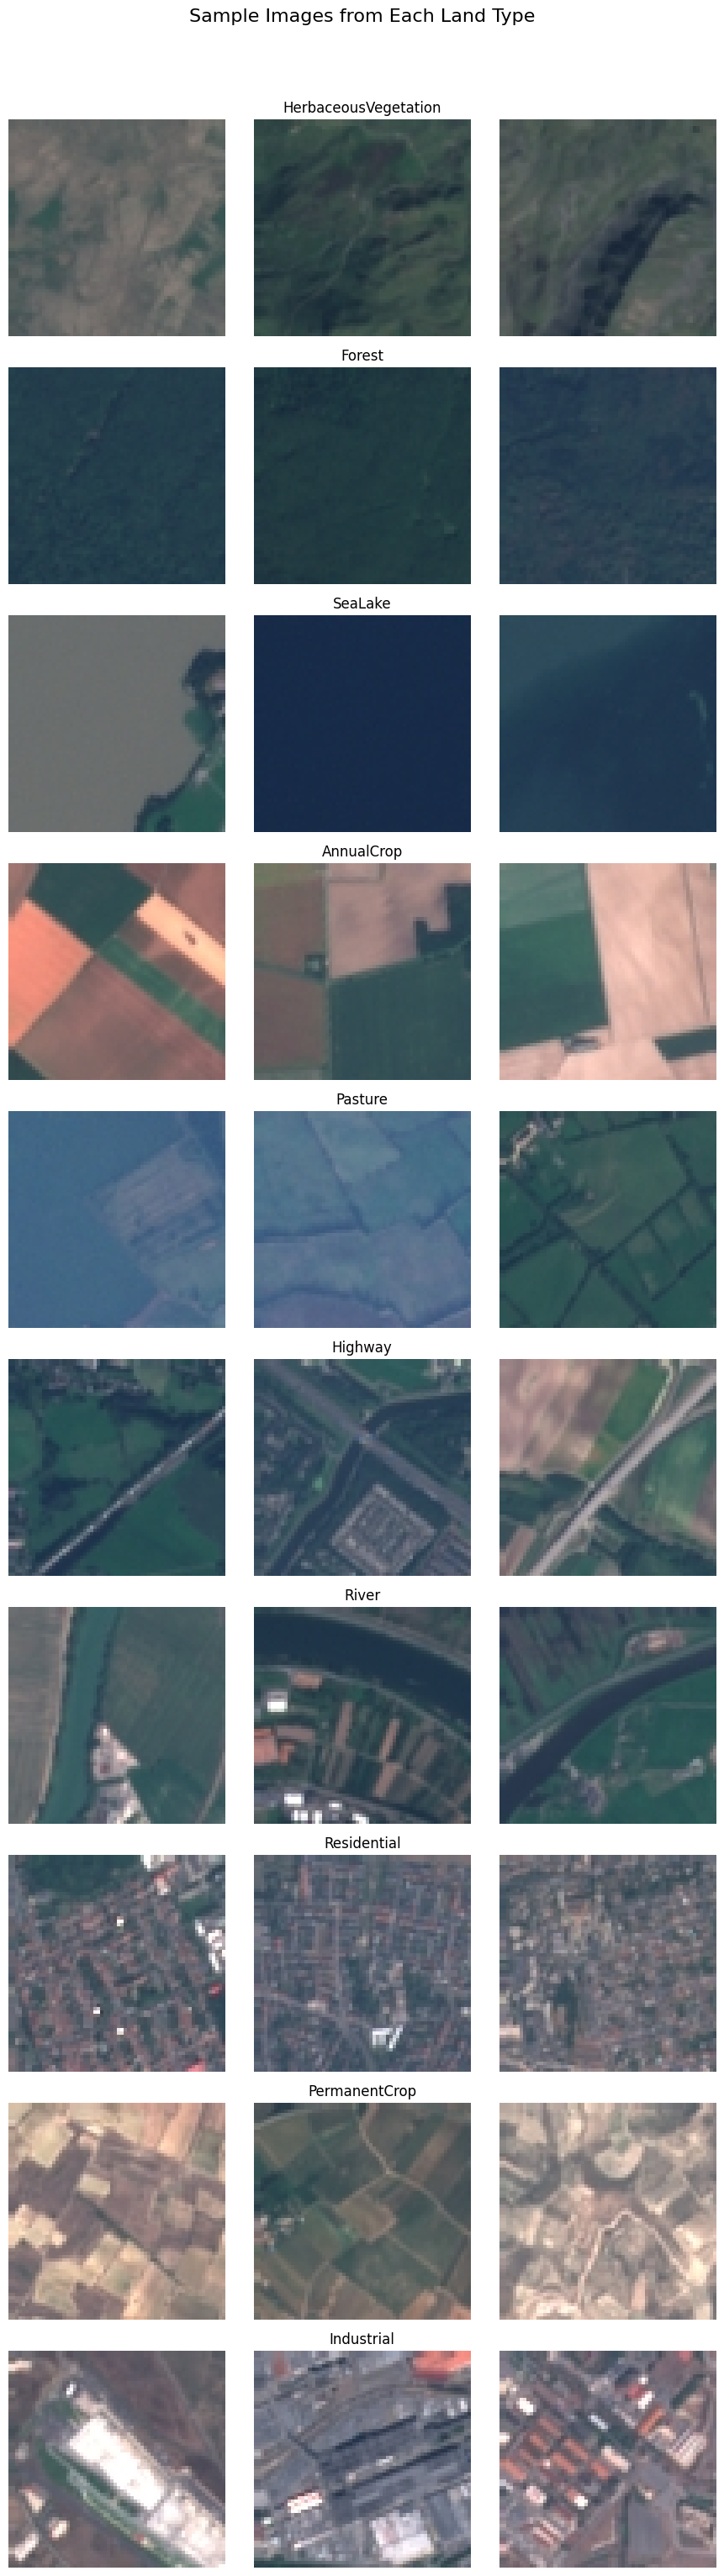

Class Distribution:
 HerbaceousVegetation    3000
Forest                  3000
SeaLake                 3000
AnnualCrop              3000
Pasture                 2000
Highway                 2500
River                   2500
Residential             3000
PermanentCrop           2500
Industrial              2500
dtype: int64


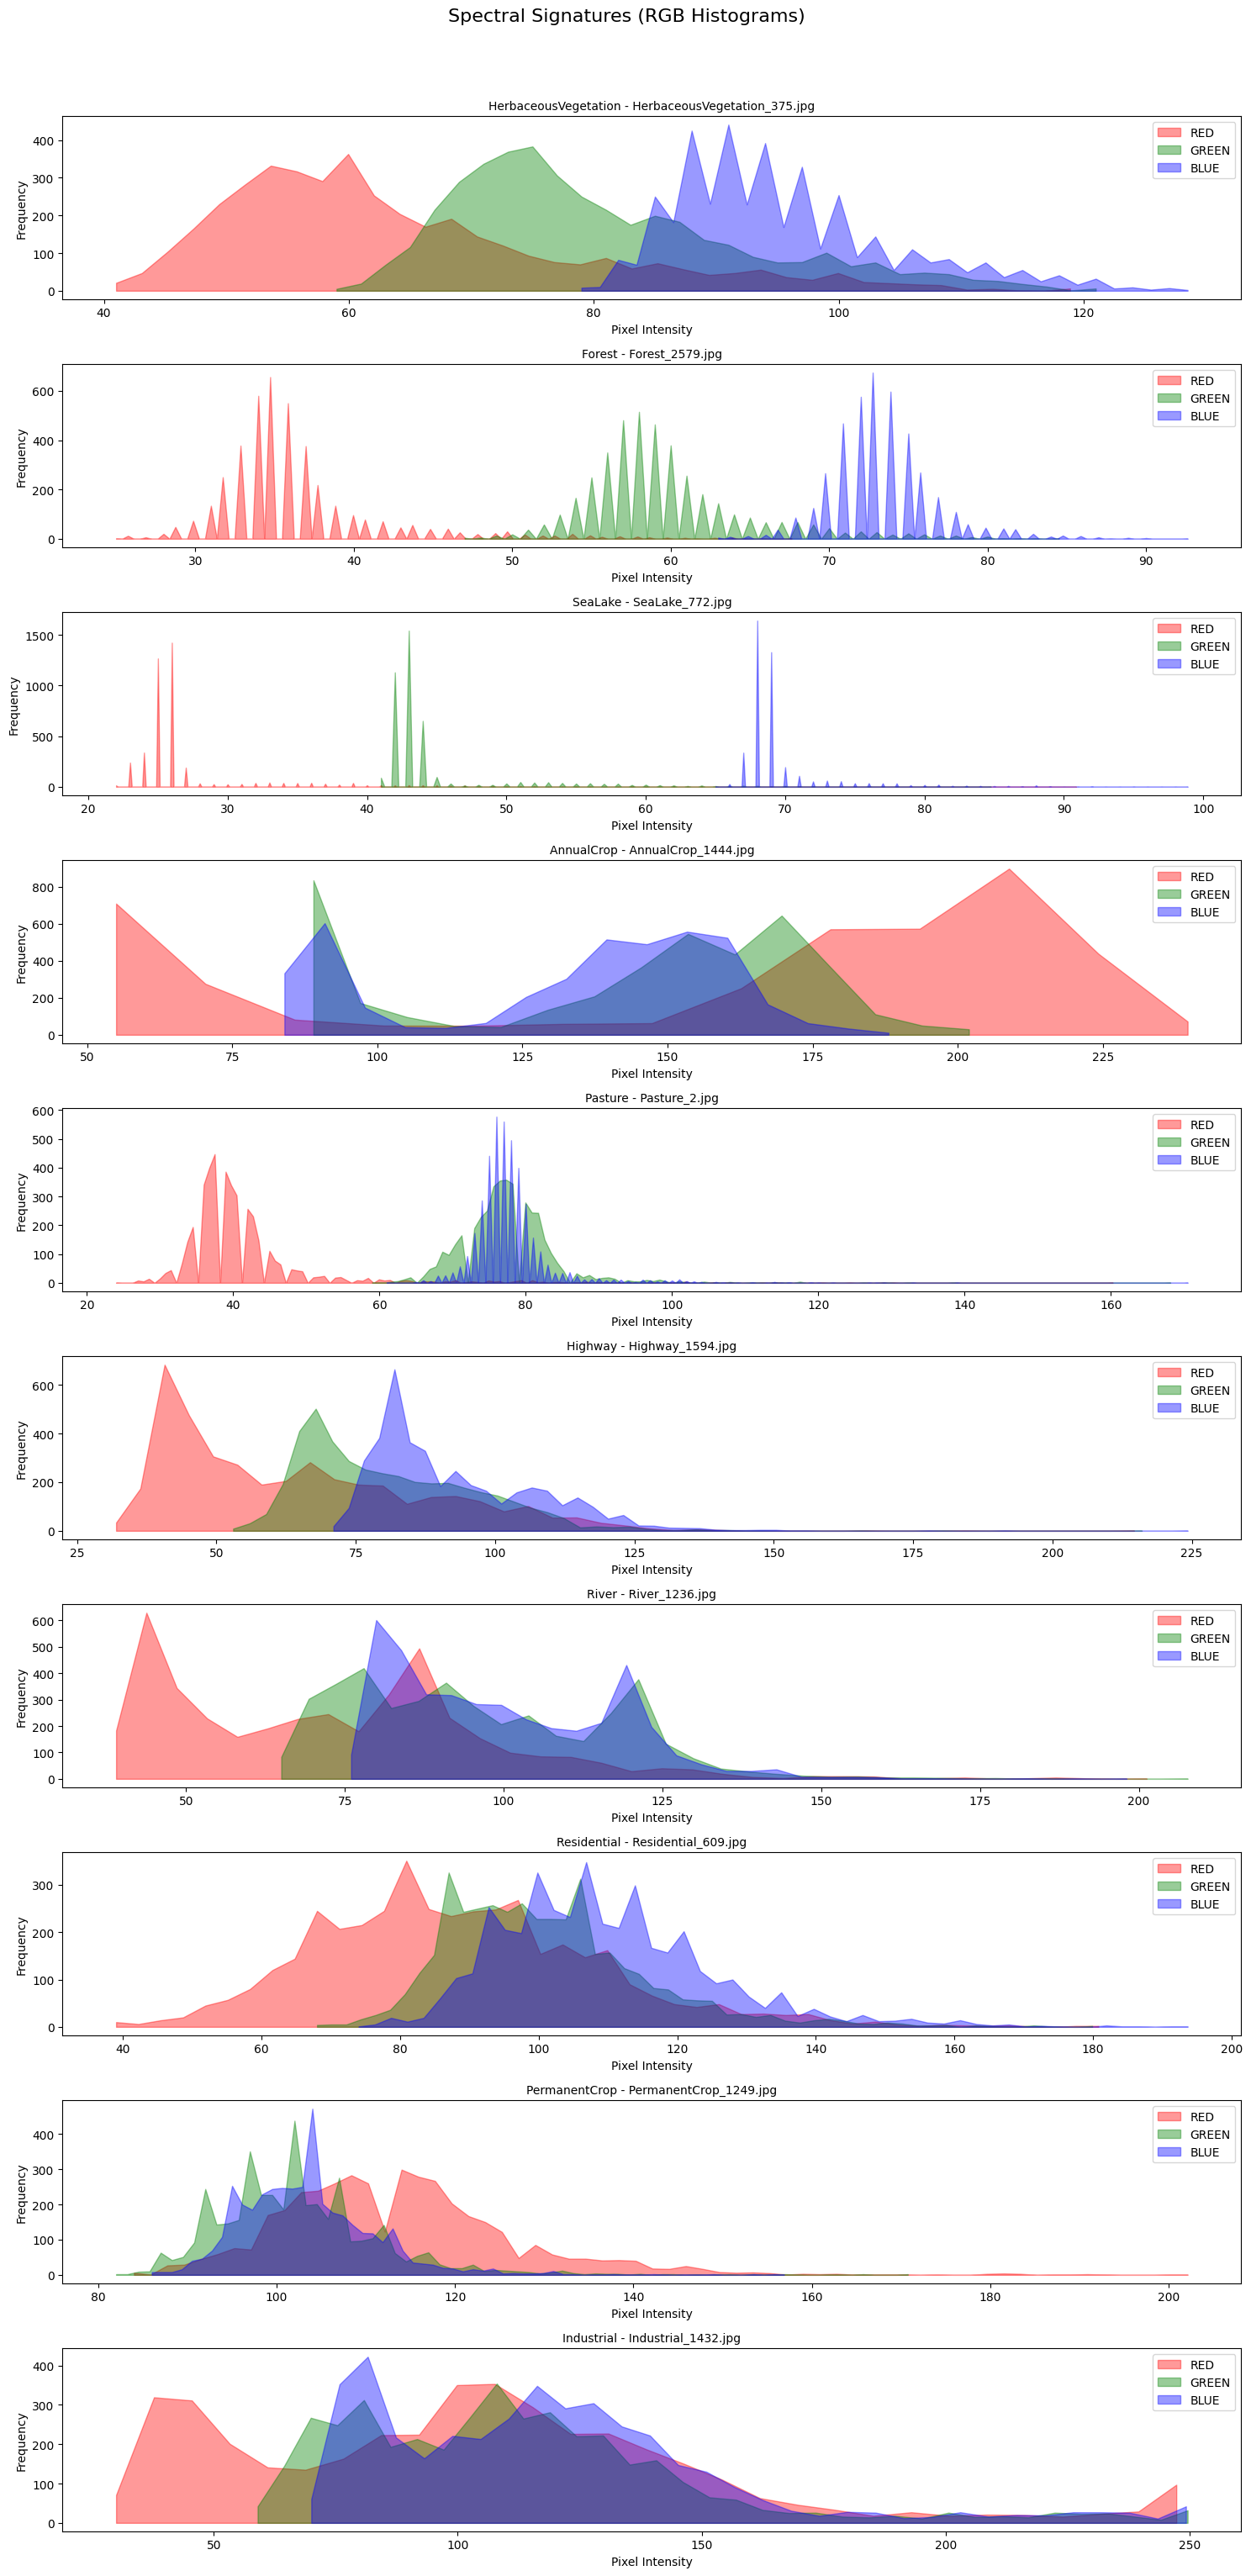

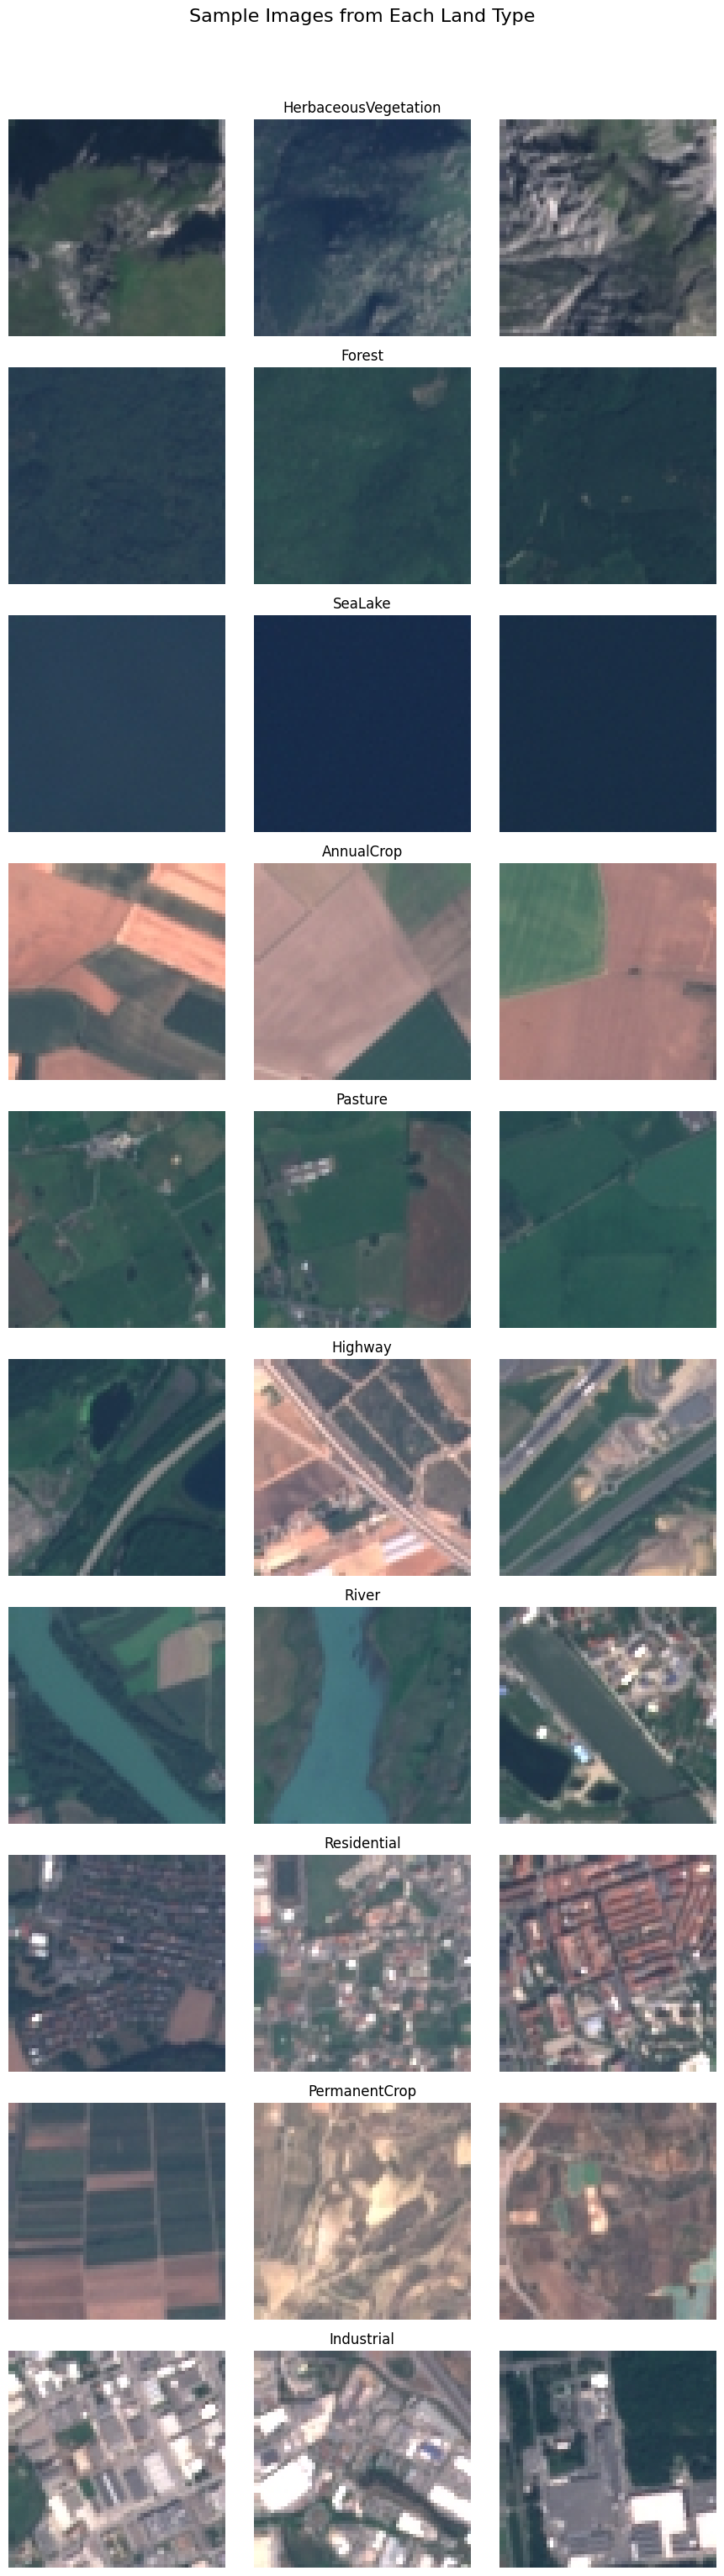

Class Distribution:
 HerbaceousVegetation    3000
Forest                  3000
SeaLake                 3000
AnnualCrop              3000
Pasture                 2000
Highway                 2500
River                   2500
Residential             3000
PermanentCrop           2500
Industrial              2500
dtype: int64


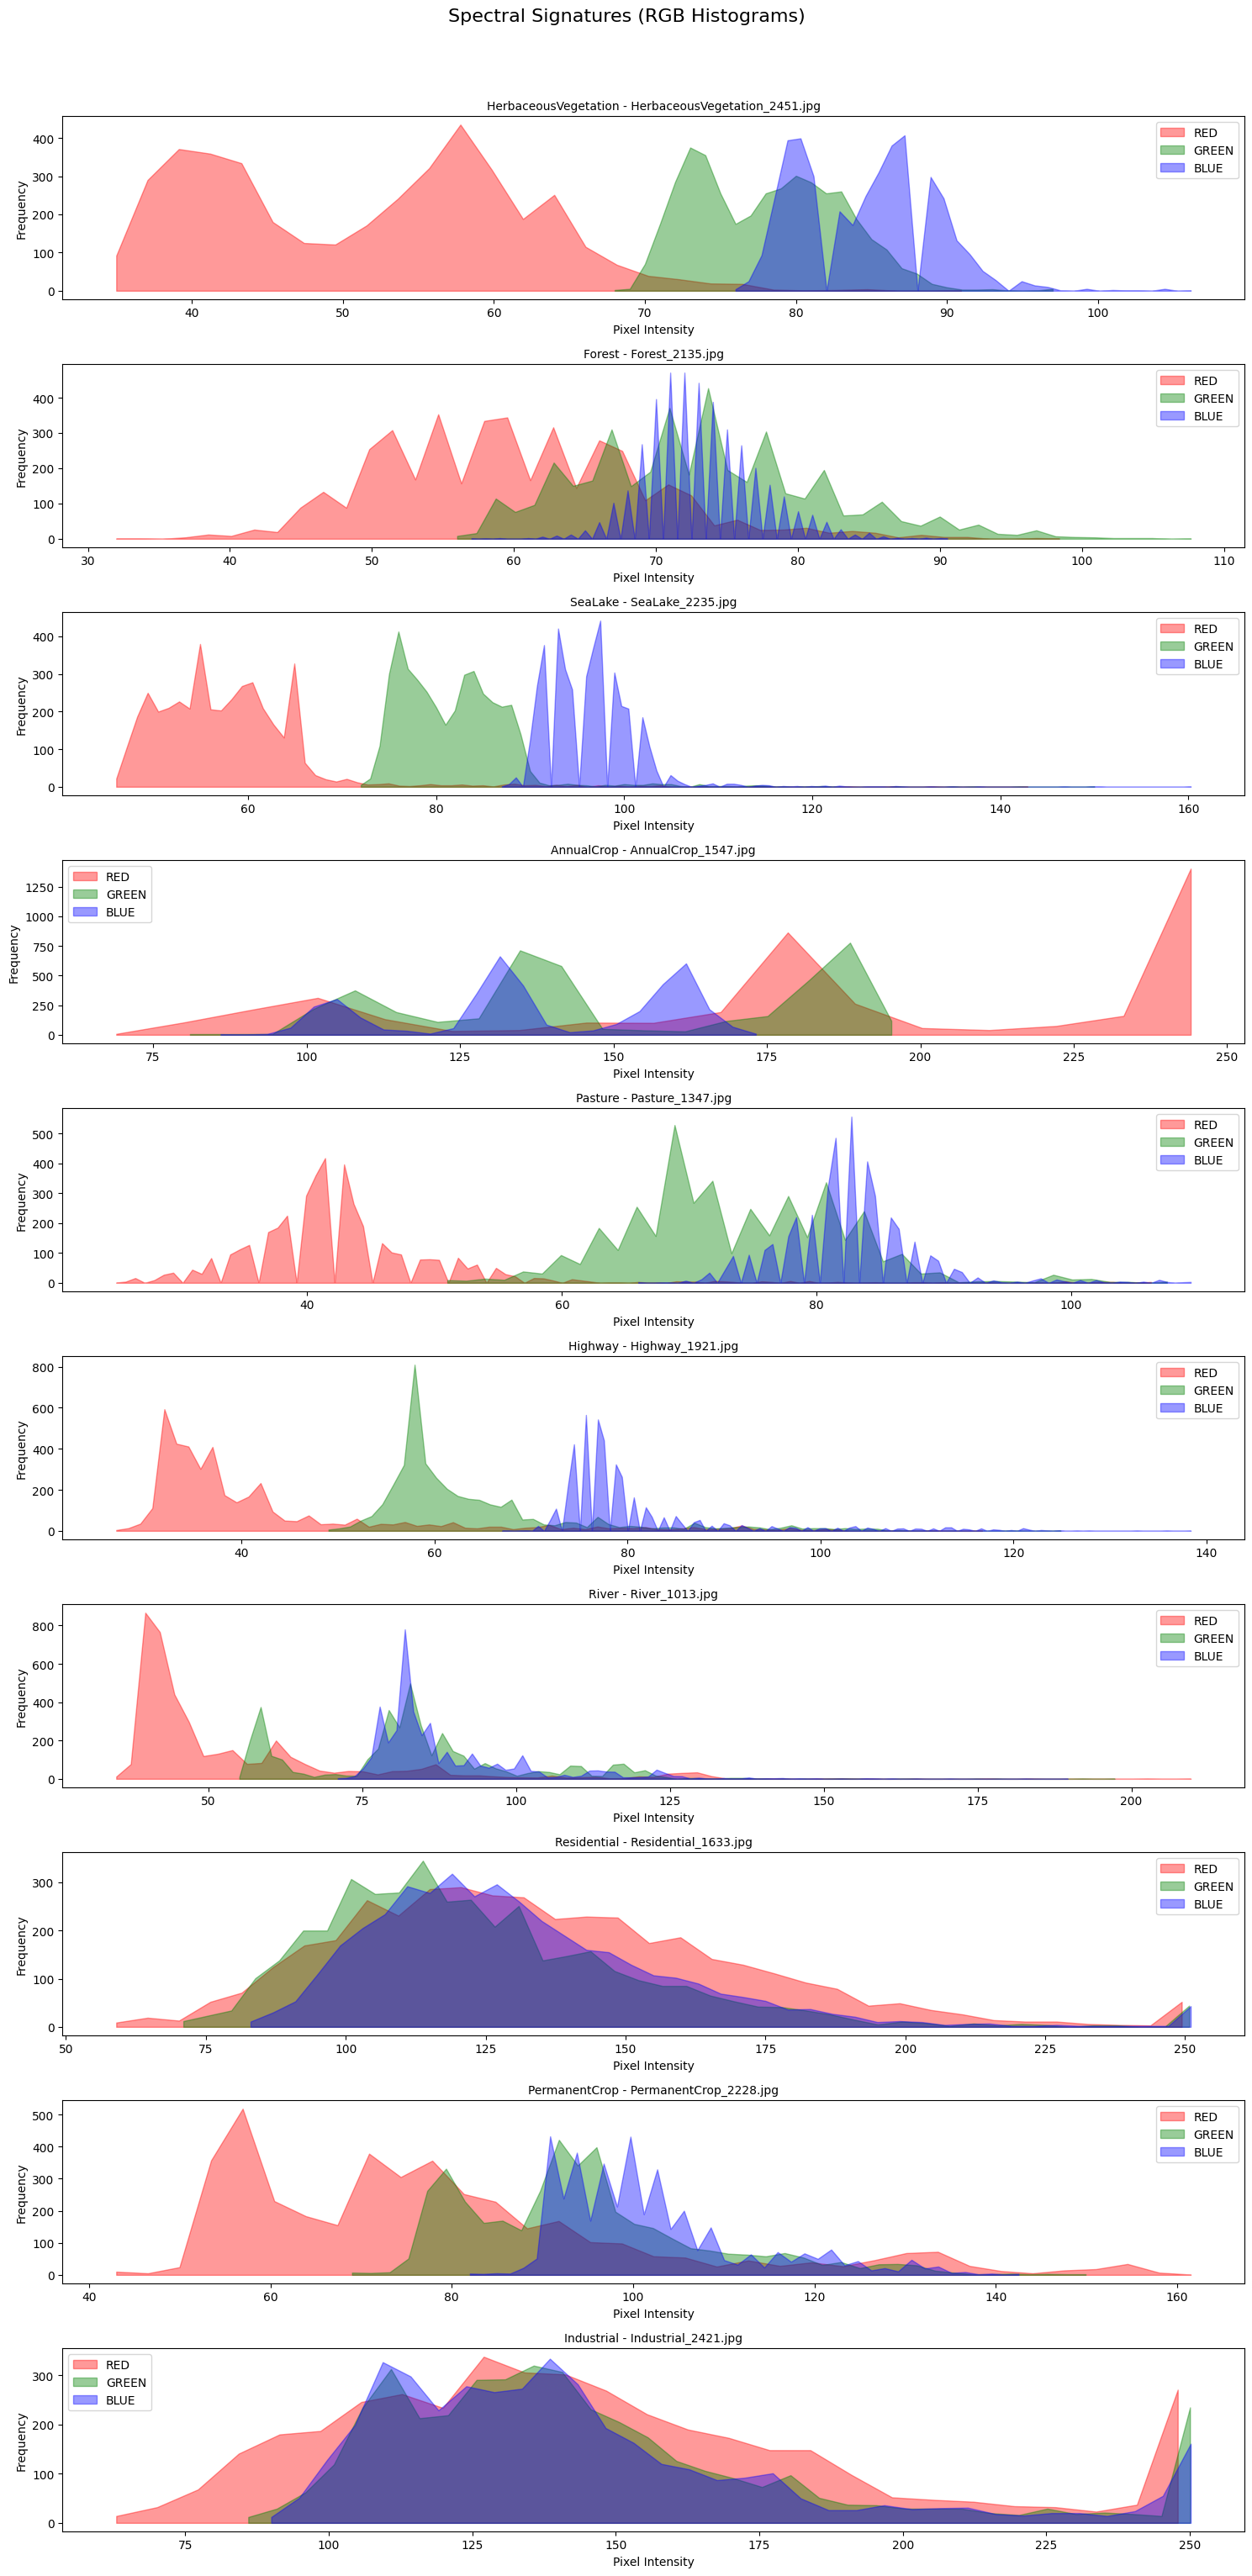

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load and visualize sample images from different land types
def plot_sample_images(land_types, dataset_path, num_samples=3):
    plt.figure(figsize=(num_samples * 3, len(land_types) * 3))
    plt.suptitle("Sample Images from Each Land Type", fontsize=16, y=1.02)

    for i, land_type in enumerate(land_types):
        land_type_path = os.path.join(dataset_path, land_type)
        all_images = [f for f in os.listdir(land_type_path) if f.endswith(('.jpg', '.png'))]

        if len(all_images) < num_samples:
            print(f"Warning: {land_type} has only {len(all_images)} images.")

        sample_images = random.sample(all_images, min(num_samples, len(all_images)))  # Handle small classes

        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(land_type_path, img_name)
            try:
                img = load_img(img_path)
                plt.subplot(len(land_types), num_samples, i * num_samples + j + 1)
                plt.imshow(img)
                plt.axis('off')
                if j == 1:
                    plt.title(land_type, fontsize=12)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    plt.tight_layout()
    plt.show()

# Inspect dataset for potential issues (imbalanced classes, missing data)
def inspect_dataset(land_types, dataset_path):
    land_type_counts = {}

    # Count images per class
    for land_type in land_types:
        land_type_path = os.path.join(dataset_path, land_type)
        land_type_counts[land_type] = len([f for f in os.listdir(land_type_path) if f.endswith(('.jpg', '.png'))])

    # Print class distribution
    class_counts = pd.Series(land_type_counts)
    print("Class Distribution:\n", class_counts)

    # Check for corrupted or mislabeled files
    for land_type in land_types:
        land_type_path = os.path.join(dataset_path, land_type)
        for img_name in os.listdir(land_type_path):
            img_path = os.path.join(land_type_path, img_name)
            try:
                img = load_img(img_path)  # Try loading image
            except Exception as e:
                print(f"⚠️ Error loading image {img_path}: {e}")

# Visualize spectral signatures (RGB histograms) of sample images
def plot_spectral_signatures(land_types, dataset_path, num_samples=1):
    plt.figure(figsize=(15, len(land_types) * 3))
    plt.suptitle("Spectral Signatures (RGB Histograms)", fontsize=16, y=1.02)

    for i, land_type in enumerate(land_types):
        land_type_path = os.path.join(dataset_path, land_type)
        all_images = [f for f in os.listdir(land_type_path) if f.endswith(('.jpg', '.png'))]

        if not all_images:
            print(f"⚠️ No images found for {land_type}. Skipping.")
            continue

        sample_images = random.sample(all_images, min(num_samples, len(all_images)))  # Handle small classes

        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(land_type_path, img_name)
            try:
                img = img_to_array(load_img(img_path))  # Convert to NumPy array

                plt.subplot(len(land_types), num_samples, i * num_samples + j + 1)
                colors = ['red', 'green', 'blue']

                for channel, color in enumerate(colors):
                    hist_values, bins = np.histogram(img[:, :, channel].flatten(), bins='auto')  # Adaptive bins
                    plt.fill_between(bins[:-1], hist_values, color=color, alpha=0.4, label=color.upper())  # Smooth hist

                plt.title(f'{land_type} - {img_name}', fontsize=10)
                plt.xlabel('Pixel Intensity')
                plt.ylabel('Frequency')
                plt.legend()
            except Exception as e:
                print(f"⚠️ Error processing image {img_path}: {e}")

    plt.tight_layout()
    plt.show()

# Usage
dataset_path = "/root/.cache/kagglehub/datasets/ahmedeleawa/eurosat-rgb/versions/1/2750/"
land_types = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

plot_sample_images(land_types, dataset_path)
inspect_dataset(land_types, dataset_path)
plot_spectral_signatures(land_types, dataset_path)


# Plot sample images
plot_sample_images(land_types, dataset_path)

# Inspect dataset for issues
inspect_dataset(land_types, dataset_path)

# Plot spectral signatures
plot_spectral_signatures(land_types, dataset_path)


# **Preprocessing and Feature Engineering**


This section includes the following steps:
- Image resizing to ensure consistent input size.
- Normalization of pixel values for faster convergence.
- Calculation of vegetation indices such as NDVI for better feature representation.
- Image augmentation to enhance dataset diversity.
- Splitting the data into training, validation, and test sets.


In [ ]:
import os

root_dir = "/root/.cache/kagglehub/datasets/ahmedeleawa/eurosat-rgb/versions/1/2750/"
if os.path.exists(root_dir):
    print("Directory exists!")
    files = os.listdir(root_dir)
    print(f"Number of files: {len(files)}")
    for file in files[:5]:
        print(file)
else:
    print("Directory not found!")


Directory exists!
Number of files: 10
HerbaceousVegetation
Forest
SeaLake
AnnualCrop
Pasture


# Check if All Images in the Dataset are **64x64**




In [ ]:
import os
from PIL import Image

def check_image_sizes_64x64(dataset_path, land_types):
    expected_size = (64, 64)  # Set the expected size to 64x64

    # Flag to check if there are any mismatches
    mismatch_found = False

    for land_type in land_types:
        land_type_path = os.path.join(dataset_path, land_type)

        print(f"Checking images in land type: {land_type}")

        for img_name in os.listdir(land_type_path):
            img_path = os.path.join(land_type_path, img_name)
            try:
                img = Image.open(img_path)
                img_size = img.size  # (width, height)

                if img_size != expected_size:
                    print(f"Image size mismatch in {land_type}: {img_name} has size {img_size} but expected {expected_size}")
                    mismatch_found = True

            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    if not mismatch_found:
        print("All images have the correct size of 64x64 across all classes.")
    else:
        print("Some images have mismatched sizes.")

# Usage
dataset_path = "/root/.cache/kagglehub/datasets/ahmedeleawa/eurosat-rgb/versions/1/2750/"
land_types = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

check_image_sizes_64x64(dataset_path, land_types)


Checking images in land type: HerbaceousVegetation
Checking images in land type: Forest
Checking images in land type: SeaLake
Checking images in land type: AnnualCrop
Checking images in land type: Pasture
Checking images in land type: Highway
Checking images in land type: River
Checking images in land type: Residential
Checking images in land type: PermanentCrop
Checking images in land type: Industrial
All images have the correct size of 64x64 across all classes.


# Check for Corrupted Images in the Dataset






In [ ]:
import os
from PIL import Image

def check_for_corrupt_images(dataset_path, land_types):
    corrupt_images = []  # List to store any corrupt image paths

    for land_type in land_types:
        land_type_path = os.path.join(dataset_path, land_type)

        print(f"Checking for corrupt images in land type: {land_type}")

        for img_name in os.listdir(land_type_path):
            img_path = os.path.join(land_type_path, img_name)
            try:
                img = Image.open(img_path)
                img.verify()  # Verify that the image is not corrupt
            except Exception as e:
                print(f"Corrupt image found: {img_path} - Error: {e}")
                corrupt_images.append(img_path)  # Add corrupt image to the list

    if not corrupt_images:
        print("No corrupt images found.")
    else:
        print(f"Found {len(corrupt_images)} corrupt images.")

# Usage
dataset_path = "/root/.cache/kagglehub/datasets/ahmedeleawa/eurosat-rgb/versions/1/2750/"
land_types = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

check_for_corrupt_images(dataset_path, land_types)

Checking for corrupt images in land type: HerbaceousVegetation
Checking for corrupt images in land type: Forest
Checking for corrupt images in land type: SeaLake
Checking for corrupt images in land type: AnnualCrop
Checking for corrupt images in land type: Pasture
Checking for corrupt images in land type: Highway
Checking for corrupt images in land type: River
Checking for corrupt images in land type: Residential
Checking for corrupt images in land type: PermanentCrop
Checking for corrupt images in land type: Industrial
No corrupt images found.


In [ ]:
image_paths = [os.path.join(root_dir, file) for file in os.listdir(root_dir) if file.endswith('.jpg')]
print(f"Found {len(image_paths)} images")

Found 0 images


In [ ]:
from glob import glob
image_paths = glob("/root/.cache/kagglehub/datasets/ahmedeleawa/eurosat-rgb/versions/1/2750/*/*.jpg")
print(f"Found {len(image_paths)} images")


Found 27000 images


In [ ]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# encoding labels of classes
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
print(f"Unique labels: {label_encoder.classes_}")

# spliting data for test
X_train, X_temp, y_train, y_temp = train_test_split(resized_images, labels_encoded, test_size=0.3, stratify=labels_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")


NameError: name 'labels' is not defined

This section includes the following steps:

**NDVI (Normalized Difference Vegetation Index):**

* NDVI is calculated using red and near-infrared bands (green band was considered as an alternative here).

* Positive values refer to plant areas, while negative values refer to water or urban areas.



**Texture Analysis:**

* Mean: The average value of pixels around each point.
* Standard deviation: Standard deviation, which determines how dispersed values are around the mean.
* Contrast: Contrast, which highlights areas with large differences in values.





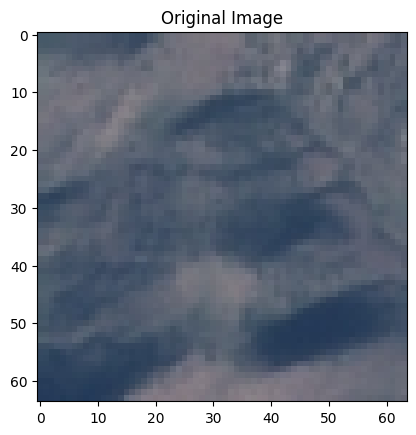

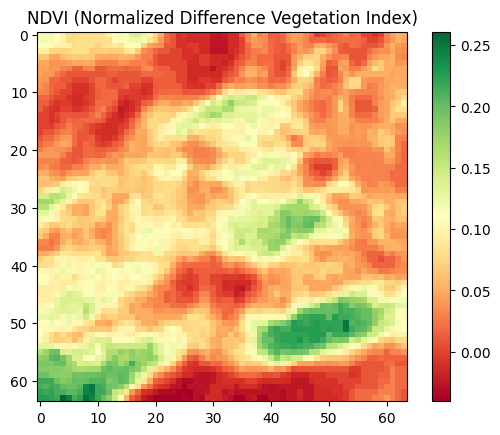

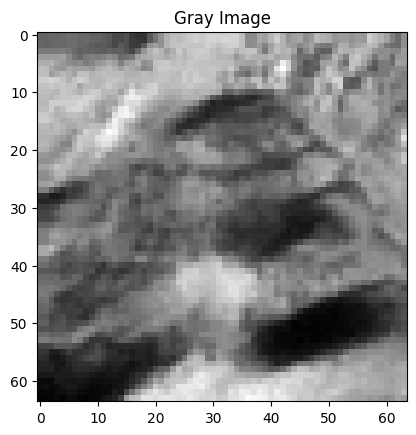

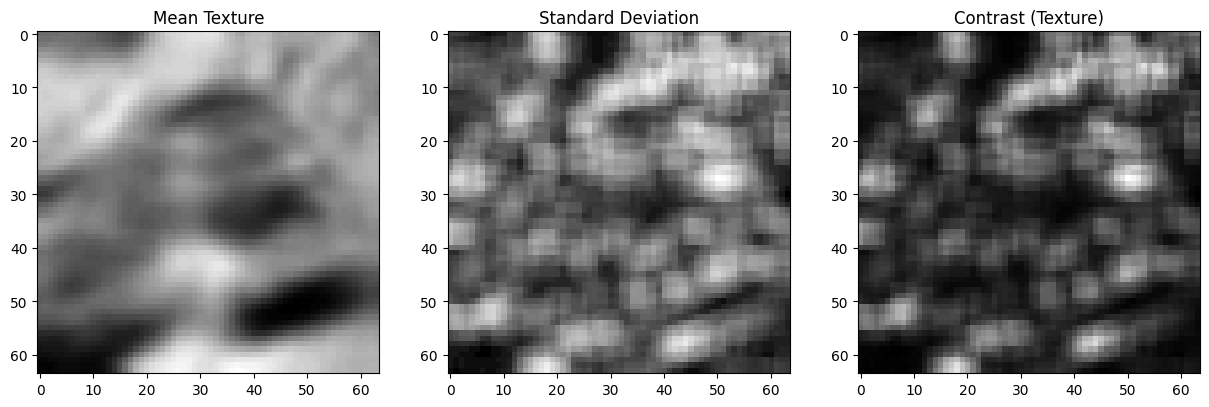

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread(image_paths[0])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.show()

# 1. Calculate NDVI (Normalized Difference Vegetation Index)
def calculate_ndvi(image):
    image = image.astype(np.float32)
    red = image[:, :, 2]  #Red area
    nir = image[:, :, 1]  # النطاق القريب من الأشعة تحت الحمراء (نعتبر النطاق الأخضر كبديل)

    ndvi = (nir - red) / (nir + red + 1e-6)
    return ndvi

ndvi = calculate_ndvi(img)
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title("NDVI (Normalized Difference Vegetation Index)")
plt.show()


# 2.(Texture Analysis)

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img, cmap='gray')
plt.title("Gray Image")
plt.show()


def texture_features(img, ksize=5):
    mean = cv2.blur(img, (ksize, ksize))
    stddev = np.sqrt(cv2.blur((img - mean)**2, (ksize, ksize)))
    contrast = stddev ** 2
    return mean, stddev, contrast

mean, stddev, contrast = texture_features(gray_img)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(mean, cmap='gray')
plt.title("Mean Texture")

plt.subplot(1, 3, 2)
plt.imshow(stddev, cmap='gray')
plt.title("Standard Deviation")

plt.subplot(1, 3, 3)
plt.imshow(contrast, cmap='gray')
plt.title("Contrast (Texture)")

plt.show()


* Gaussian Blur (3x3) for noise reduction
* CLAHE (Contrast Enhancement) for better visibility
* Sharpening to enhance details
* Edge Detection (Canny) to test feature extraction
* Train/Test/Validation Split

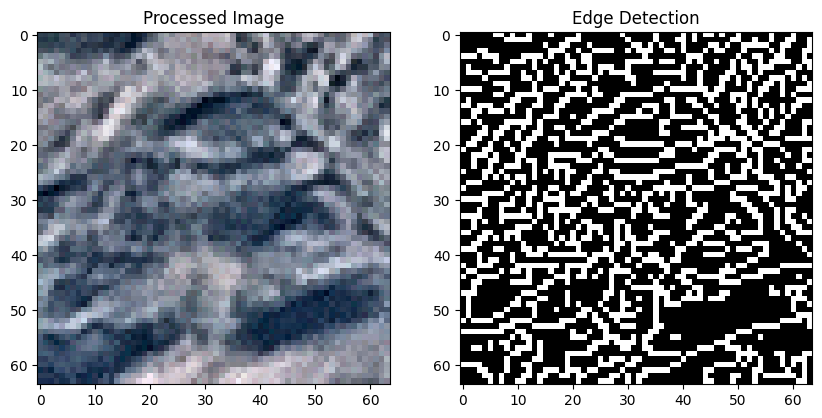

Training set: 18900, Validation set: 4050, Test set: 4050


In [ ]:
import os
import cv2
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Set dataset path
dataset_path = "/root/.cache/kagglehub/datasets/ahmedeleawa/eurosat-rgb/versions/1/2750/"
land_types = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# Function to apply Gaussian Blur (Noise Reduction)
def apply_gaussian_blur(img_array, kernel_size=(3, 3), sigmaX=1):
    return cv2.GaussianBlur(img_array, kernel_size, sigmaX)

# Function to apply CLAHE for Contrast Enhancement
def apply_clahe(img_array):
    lab = cv2.cvtColor(img_array, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    enhanced_lab = cv2.merge((l, a, b))
    return cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)

# Function to apply Sharpening
def sharpen_image(img_array):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(img_array, -1, kernel)

# Function to apply Edge Detection
def apply_edge_detection(img_array):
    gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    return edges

# Function to preprocess images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = apply_gaussian_blur(img)
    img = apply_clahe(img)
    img = sharpen_image(img)
    edges = apply_edge_detection(img)
    return img / 255.0, edges

# Load and preprocess sample images
image_paths = [os.path.join(root, file) for root, _, files in os.walk(dataset_path) for file in files if file.endswith(('.jpg', '.png'))]
processed_img, edges = preprocess_image(image_paths[0])

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(processed_img)
plt.title("Processed Image")

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title("Edge Detection")
plt.show()

# Split dataset into train, val, and test sets
label_encoder = LabelEncoder()
labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]
labels_encoded = label_encoder.fit_transform(labels)
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels_encoded, test_size=0.3, stratify=labels_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Training set: {len(X_train)}, Validation set: {len(X_val)}, Test set: {len(X_test)}")


* Class distribution visualization
* Pixel intensity histograms for multiple images
* Correlation heatmap to analyze feature relationships
*  Random sample images from different land types
*  flattening to convert images into 1D vectors before PCA and t-SNE







In [ ]:
# Flatten images for further analysis
def flatten_image(img):
    return img.flatten()

flattened_images = np.array([flatten_image(cv2.imread(img, cv2.IMREAD_GRAYSCALE)) for img in image_paths[:500]])
labels_subset = [os.path.basename(os.path.dirname(path)) for path in image_paths[:500]]

<ipython-input-21-1890836fe245>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels_encoded, palette='viridis')


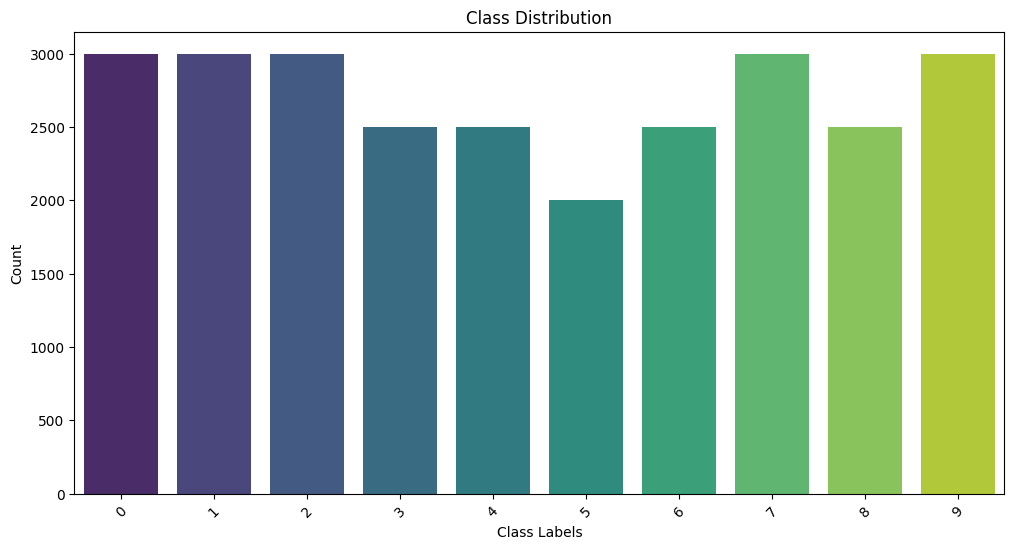

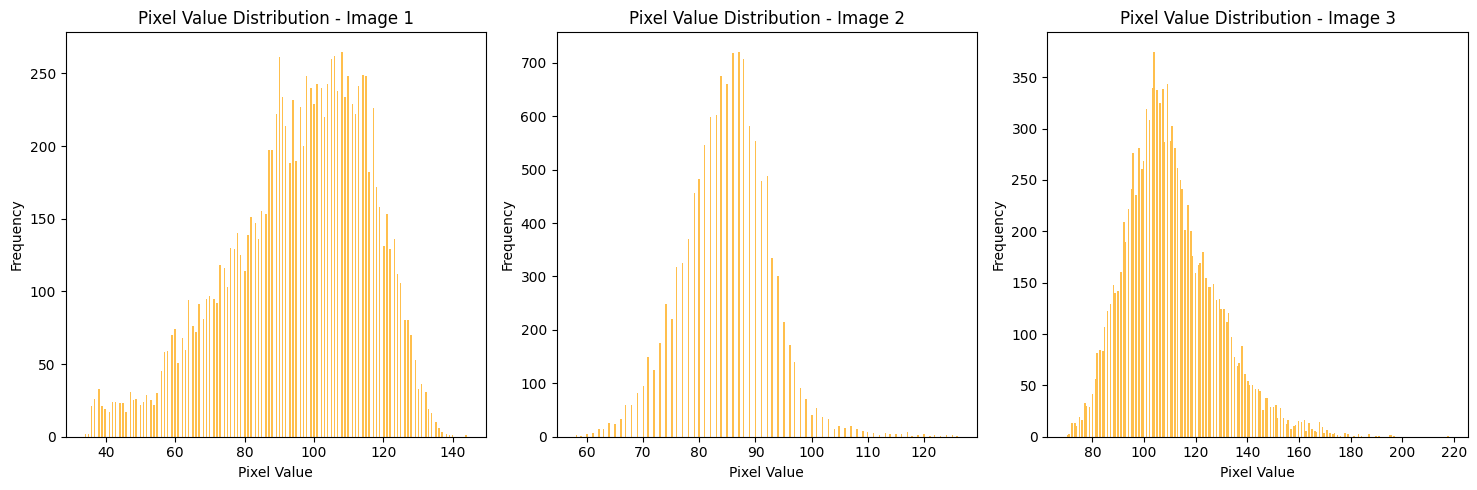

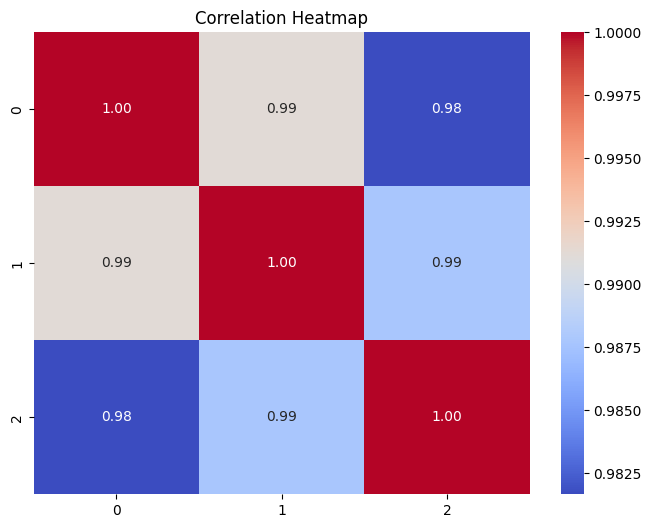

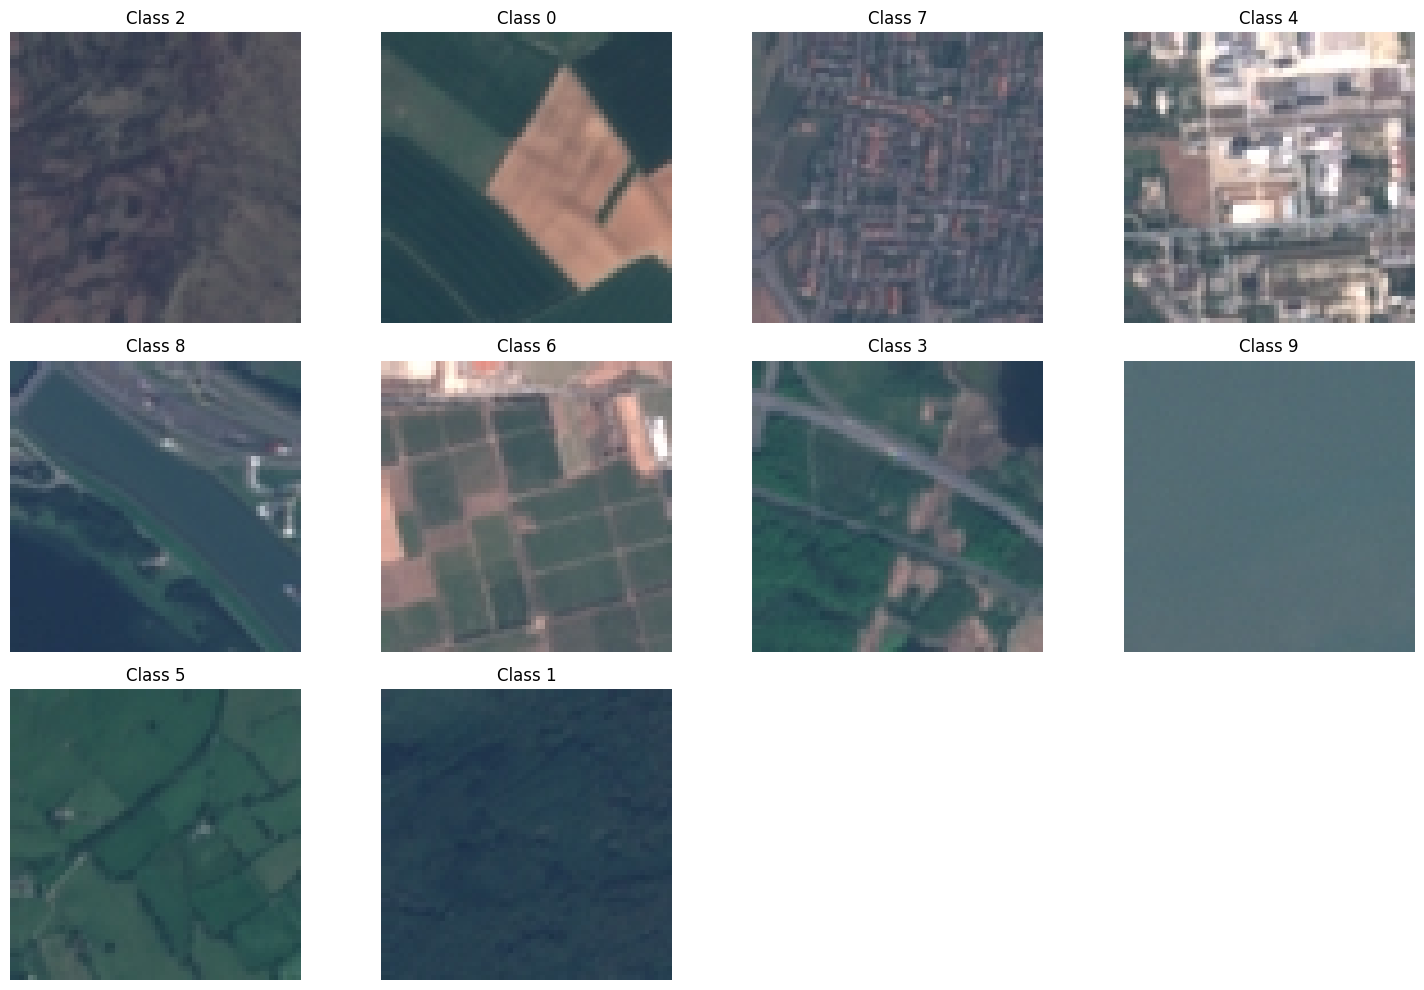

In [ ]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 6))
sns.countplot(x=labels_encoded, palette='viridis')
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

# Display pixel value distribution for multiple sample images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    sample_img = cv2.imread(image_paths[i])
    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
    axes[i].hist(sample_img.ravel(), bins=256, color='orange', alpha=0.7)
    axes[i].set_title(f'Pixel Value Distribution - Image {i+1}')
    axes[i].set_xlabel('Pixel Value')
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

# Correlation heatmap of a sample image
sample_img = cv2.imread(image_paths[0])
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
corr_matrix = np.corrcoef(sample_img.reshape(-1, 3), rowvar=False)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

import matplotlib.pyplot as plt
import cv2
import random

# Ensure at least one image per class is displayed
unique_classes = list(set(labels_encoded))
random.shuffle(unique_classes)  # Shuffle to ensure randomness
num_classes = min(len(unique_classes), 12)  # Display up to 12 unique classes

# Adjust subplot size based on number of classes
rows = (num_classes // 4) + (1 if num_classes % 4 else 0)
fig, axes = plt.subplots(rows, 4, figsize=(15, 10))
axes = axes.ravel()

for i, cls in enumerate(unique_classes[:num_classes]):
    # Get all image paths for this class
    class_images = [img for img, lbl in zip(image_paths, labels_encoded) if lbl == cls]

    if class_images:  # Ensure there are images in this class
        img_path = random.choice(class_images)  # Pick a random image from this class
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Class {cls}")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


* PCA
* t-SNE
* Feature Vectors




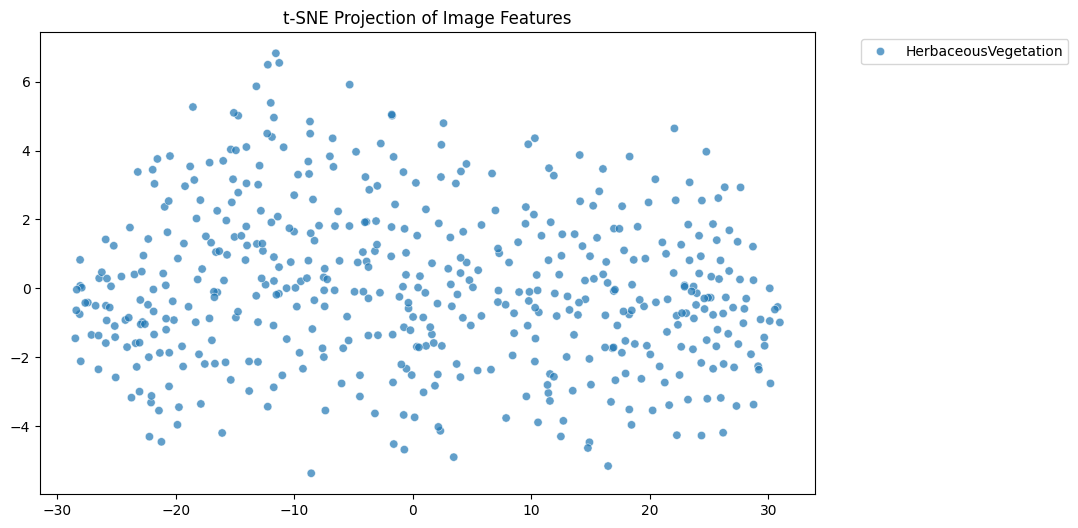

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Convert images into feature vectors for dimensionality reduction
num_samples = 500
image_features = [cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).flatten() for img_path in image_paths[:num_samples]]
labels_subset = [os.path.basename(os.path.dirname(path)) for path in image_paths[:num_samples]]

# Apply PCA
pca = PCA(n_components=50)
features_pca = pca.fit_transform(image_features)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features_pca)

# Visualize the t-SNE projection
plt.figure(figsize=(10, 6))
sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=labels_subset, palette="tab10", alpha=0.7)
plt.title("t-SNE Projection of Image Features")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()